In [21]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math

In [22]:
# Centroid Calcuation

def calcCentroid(data, xCord, yCord, pRad):

  #X Calculation

  data = np.array(data)
  
  sumArrayX = data.sum(axis = 0) 
  
  weightMeanX = 0
  sumColumn = 0
  for i in range(len(sumArrayX)):
    weightMeanX += sumArrayX[i] * (i+1)
    sumColumn += sumArrayX[i]
  x = weightMeanX/sumColumn 

  #Y Calculation 
  sumArrayY = data.sum(axis = 1)

  weightMeanY = 0
  sumRow = 0
  for i in range(len(sumArrayY)):
    weightMeanY += sumArrayY[i] * (i+1)
    sumRow += sumArrayY[i]
  y = weightMeanY/sumRow

  uncertaintyX, uncertaintyY = obtainUncertainty(sumArrayX, sumArrayY, [x,y])

  return [x + xCord - (pRad), y + yCord - (pRad), uncertaintyX, uncertaintyY]

def obtainUncertainty(xArray, yArray, cen):
  x, y = cen
  

  #X Calculation
  sumX = sum(xArray)
  arrayUnCertainX = []
  for i in range(len(xArray)):
    arrayUnCertainX.append(((i + 1) - x) ** 2)
  
  numeratorX = 0
  for i in range(len(xArray)):
    numeratorX += xArray[i] * arrayUnCertainX[i]
  uncertaintyX = math.sqrt((numeratorX)/(sumX * (sumX-1)))


  #Y Calculation
  sumY = sum(yArray)
  arrayUnCertainY = []
  for i in range(len(yArray)):
    arrayUnCertainY.append(((i + 1) - y) ** 2)
  
  numeratorY = 0
  for i in range(len(yArray)):
    numeratorY += yArray[i] * arrayUnCertainY[i]
  uncertaintyY = math.sqrt((numeratorY)/(sumY * (sumY-1)))

  return uncertaintyX, uncertaintyY

In [23]:
def obtainROI(pRad, xCord, yCord, data, avgBckg):
  refinedData = data[yCord - pRad: yCord + pRad + 1, xCord - pRad: xCord + pRad + 1]

  refinedData, rawData = obtainCircleData(refinedData, pRad, avgBckg)
  plt.imshow(refinedData)
 # plt.gray()
  plt.show()

  return refinedData, rawData

In [24]:
def obtainCircleData(processedData, pRad, avgBckg):
  circleData = np.array(processedData).copy()
  circleData.fill(0)
  radius = len(processedData)/2
  center = round((len(processedData)-1)/2)

  for i in range(len(circleData)):
    for j in range(len(circleData[i])):
      distance = math.sqrt((j - center)**2 + (i - center)**2)
      if distance <= pRad:
        circleData[i][j] = 1
  
  apertureCentroid = processedData * circleData

  aperture = processedData * circleData

  apertureCentroid = processedData.tolist()

  # Subtract Background Noise from Aperture
  for i in range(len(apertureCentroid)):
    for j in range(len(apertureCentroid[i])):
      if (apertureCentroid[i][j] != 0):        
        apertureCentroid[i][j] = float(apertureCentroid[i][j]) - float(avgBckg)

  return apertureCentroid, aperture

In [25]:
def calculateAvgBckg(data, rIn, rOut, xCord, yCord):
  annulusMap = np.array(data).copy()
  annulusMap = annulusMap[yCord - rOut: yCord + rOut + 1, xCord - rOut: xCord + rOut + 1]
  annulusMap.fill(0)

  annulusData = np.array(data).copy()
  annulusData = annulusData[yCord - rOut: yCord + rOut + 1, xCord - rOut: xCord + rOut + 1]

  center = round((len(annulusMap)-1)/2)

  for i in range(len(annulusMap)):
    for j in range(len(annulusMap[i])):
      distance = math.sqrt((j - center)**2 + (i - center)**2)
      if distance <= rOut:
        annulusMap[i][j] = 1
    
  for i in range(len(annulusMap)):
    for j in range(len(annulusMap[i])):
      distance = math.sqrt((j - center)**2 + (i - center)**2)
      if distance <= rIn:
        annulusMap[i][j] = 0
      
  annulusData = annulusData * annulusMap
  sumAnnulus = sum(map(sum, annulusData))
  totalElementsAnnulus = np.count_nonzero(annulusData)
  return sumAnnulus/totalElementsAnnulus, annulusData

In [26]:
def obtainPhotometry(fileName, xCord, yCord, pRad, rIn, rOut):
  avgBckg, annulusData = calculateAvgBckg(fits.getdata(fileName), rIn, rOut, xCord, yCord)
  apertureCentroid, aperture = obtainROI(pRad, xCord, yCord, fits.getdata(fileName), avgBckg)
  centroid = calcCentroid(apertureCentroid, xCord, yCord, pRad)
  signal = obtainSignal(aperture, annulusData)
  instMag = -2.5 * math.log(signal, 10)
  SNR, magUncert, signalUncert = obtainSNR(aperture, annulusData, avgBckg, signal)
  return centroid, signal, instMag, SNR, magUncert, signalUncert

In [27]:
def obtainSignal(apertureData, annulusData):

  aduAP = sum(map(sum, apertureData))
  nAP = np.count_nonzero(apertureData)

  aduAN = sum(map(sum, annulusData))
  nAN = np.count_nonzero(annulusData)

  signal = aduAP - nAP * (aduAN/nAN)
  
  return signal

In [28]:
def obtainSNR(apertureData, annulusData, avgBckg, signal):
  signalE = signal * .8
  nAP = np.count_nonzero(apertureData)
  nAN = np.count_nonzero(annulusData)
  darkCurrent = 10
  read = 11
  gain = .8
  skyBackground = avgBckg * .8
  electronicsNoise = read**2 + (gain**2)/12
  
  snrE = math.sqrt(signalE)/math.sqrt(1 + nAP * (1 + (nAP/nAN)) * ((skyBackground + darkCurrent + electronicsNoise)/signalE))

  snrADU = math.sqrt(signal)/math.sqrt(1 + nAP * (1 + (nAP/nAN)) * ((avgBckg + darkCurrent + electronicsNoise)/signal))

  magUncert = 1.0876/snrE

  signalUncert = signal/snrADU

  return snrE, magUncert, signalUncert

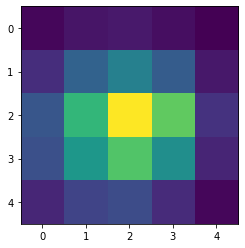

In [29]:
centroid, signal, instMag, SNR, magUncert, signalUncert = obtainPhotometry("/content/Aligned_ReducedReduced0000.fits", 412, 632, 2, 3, 5)

In [30]:
print("X Centroid: " + str(centroid[0]))
print("Y Centroid: " + str(centroid[1]))
print("Uncertainty X: " + str(centroid[2]))
print("Uncertainty Y: " + str(centroid[3]))
print("Signal: " + str(signal))
print("Instrumental Magnitude: " + str(instMag))
print("SNR: " + str(SNR))
print("Magnitude Uncertainty: " + str(magUncert))
print("Signal Uncertainty: " + str(signalUncert))

X Centroid: 412.8723683351359
Y Centroid: 633.2549256162391
Uncertainty X: 0.0026902925856135576
Uncertainty Y: 0.002455051792785336
Signal: 130287.89863586426
Instrumental Magnitude: -12.787260198918208
SNR: 303.87300504820104
Magnitude Uncertainty: 0.0035791267468049106
Signal Uncertainty: 382.79778723753174
